In [54]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,csr_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import norm
%matplotlib inline

In [55]:
data = pd.read_csv('data/round.csv').drop('Unnamed: 0',axis=1)

In [56]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [57]:
data.shape

(249822, 12)

In [58]:
data.tail()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
249817,2016,340,26,608,40098,"Fitzpatrick, Matthew",4,10:20,71,T54,55.0,0.494344
249818,2016,340,26,608,46970,"Rahm, Jon",4,11:50,70,T23,27.0,0.240950
249819,2016,340,26,608,47287,"Tracy, Ethan",4,10:10,77,T65,65.5,0.589367
249820,2016,340,26,608,47959,"DeChambeau, Bryson",4,14:50,74,T15,16.0,0.141403
249821,2016,340,26,608,50490,"Parker, Chase",4,11:50,81,64,64.0,0.575792


In [59]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [60]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [61]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [62]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)
n_tournaments = len(data.groupby(['Tournament_Year','Permanent_Tournament_#']))

In [63]:
print n_players,n_rounds,n_tournaments

2551 2754 612


In [64]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

In [65]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [21]:
def inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA,window_size=28):
    mat = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_tournament_groups,n_players),dtype=float)
    for j in rounds_to_inflate:
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % j)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % j)!=0).astype(float)*my_norm(tournament_group-k,BETA)] for k in range(1,n_tournament_groups+1)],format='csc')
    if window_size>tournament_group:
        del inflate.__dict__[window_size-tournament_group]
    inflate.__dict__[tournament_group] = (mat,mat_1)
    out_mat = bmat([[inflate.__dict__[i][0][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    out_mat1 = bmat([[inflate.__dict__[i][1][max(0,tournament_group-window_size)*n_players:n_players*tournament_group] for i in range(max(1,tournament_group-window_size+1),tournament_group+1)]],format='csc')
    return (out_mat,out_mat1)

In [67]:
def alpha(A,a):
    A.data[A.data<1e-6] = 0
    A.data[np.isnan(A.data)]=0
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [70]:
def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    mat.data[mat_1.data<1e-6] = 0
    mat_1.data[mat_1.data<1e-6] = 0
    mat.data[np.isnan(mat.data)] = 0
    mat_1.data[np.isnan(mat_1.data)] = 0
    
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    
    w_a[w_g<min_reps]=0
    solve.w_a = w_a
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [71]:
ranks,reps = [],[]
BETA = 7
a = .8
bin_size = 4
window_size = 28
n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups=[set()]
tournaments = set()
rounds_to_inflate = []
for round_ind,df in enumerate(rounds):
    df = df[1]
    tournament_groups[current_group].add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournaments.add(','.join(map(str,[df.iloc[0].Tournament_Year,df.iloc[0]['Permanent_Tournament_#']])))
    tournament_group = len(tournaments)/bin_size
    rounds_to_inflate.append(round_ind)
    if tournament_group>current_group:
        A,G = inflate(tournament_group,rounds_to_inflate,n_tournament_groups,BETA)
        if current_group==0:
            res = solve(A,G,a,1)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []
        else:
            w_a_approx = np.append(solve.w_a[0 if tournament_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if tournament_group<=window_size else n_players:],solve.w_g[-n_players:])
            res = solve(A,G,a,1,w_a_approx,w_g_approx)
            ranks.append(res[0])
            reps.append(res[1])
            print 'Tournament Group %d done' % tournament_group
            current_group = tournament_group
            tournament_groups.append(set())
            rounds_to_inflate = []

Tournament Group 1 done
Tournament Group 2 done
Tournament Group 3 done
Tournament Group 4 done
Tournament Group 5 done
Tournament Group 6 done
Tournament Group 7 done
Tournament Group 8 done
Tournament Group 9 done
Tournament Group 10 done
Tournament Group 11 done
Tournament Group 12 done
Tournament Group 13 done
Tournament Group 14 done
Tournament Group 15 done
Tournament Group 16 done
Tournament Group 17 done
Tournament Group 18 done
Tournament Group 19 done
Tournament Group 20 done
Tournament Group 21 done
Tournament Group 22 done
Tournament Group 23 done
Tournament Group 24 done
Tournament Group 25 done
Tournament Group 26 done
Tournament Group 27 done
Tournament Group 28 done
Tournament Group 29 done
Tournament Group 30 done
Tournament Group 31 done
Tournament Group 32 done
Tournament Group 33 done
Tournament Group 34 done
Tournament Group 35 done
Tournament Group 36 done
Tournament Group 37 done
Tournament Group 38 done
Tournament Group 39 done
Tournament Group 40 done
Tournamen

In [72]:
mins,maxs = [],[]
for i in range(len(ranks)):
    df = pd.DataFrame({'rank':ranks[i],'reps':reps[i]}).dropna()
    mins.append(df['rank'].min())
    maxs.append(df['rank'].max())

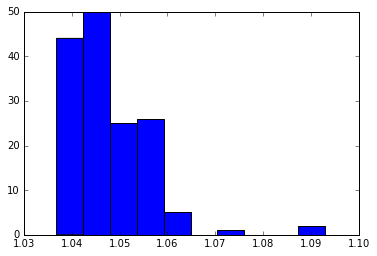

In [74]:
plt.hist(maxs);

In [23]:
def sph(x,a,b):
    if x<a:
        return min(1,b + 1.5*(x/a) - .5*(x/a)**3)
    else:
        return 1

In [33]:
data[data.Player_Name=='Oppenheim, Rob']

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Index,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
72704,2006,380,505,700,27942,1294,"Oppenheim, Rob",1,08:50,78,CUT,112.0,0.815957
72859,2006,380,505,700,27942,1294,"Oppenheim, Rob",2,14:00,70,CUT,112.0,0.815957
73171,2006,390,32,694,27942,1294,"Oppenheim, Rob",1,14:20,66,T41,42.0,0.365132
73322,2006,390,32,694,27942,1294,"Oppenheim, Rob",2,09:20,70,T41,42.0,0.365132
73401,2006,390,32,694,27942,1294,"Oppenheim, Rob",3,12:55,72,T41,42.0,0.365132
73478,2006,390,32,694,27942,1294,"Oppenheim, Rob",4,09:40,71,T41,42.0,0.365132
11815,2014,350,26,528,27942,1294,"Oppenheim, Rob",1,06:45,75,CUT,139.5,0.924888
11971,2014,350,26,528,27942,1294,"Oppenheim, Rob",2,12:30,77,CUT,139.5,0.924888
18411,2016,40,54,746,27942,1294,"Oppenheim, Rob",1,12:49,71,T54,56.5,0.578608
18531,2016,40,54,746,27942,1294,"Oppenheim, Rob",2,13:09,69,T54,56.5,0.578608


In [75]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [175]:
a,b = .95,0
ratings = []
reps_pct = []
for j in range(len(ranks)-1):
    df = pd.DataFrame({'player_ind':range(n_players),
                  'player_name':[inds_to_name[i] for i in range(n_players)],
                  'rank':ranks[j],'reps':reps[j]}).sort_values('rank',ascending=False).dropna()
    pct_reps = pd.Series(df.reps[df.reps!=0]).rank(pct=True)
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'pct_reps'] = pct_reps
#     df.insert(len(df.columns),'coeff',[sph(rep_pct,a,b) for rep_pct in df.pct_reps])
#     df.insert(len(df.columns),'new_rank',df['rank']*df.coeff)
    df2 = pd.DataFrame({'Player_Index':range(n_players),
                        'Rank':[df.loc[i]['rank'] if i in df.index else 0 for i in range(n_players)],
                        'Reps_Pct':[df.loc[i].pct_reps if i in df.index else 0 for i in range(n_players)]})
    ratings += df2.Rank.values.tolist()
    reps_pct += df2.Reps_Pct.values.tolist()
    
outcomes = []
for t_ind in range(1,len(ranks)):
    years,t_ids = [int(i.split(',')[0]) for i in tournament_groups[t_ind]],[int(i.split(',')[1]) for i in tournament_groups[t_ind]]
    years += [int(i.split(',')[0]) for i in tournament_groups[t_ind+1]]
    t_ids += [int(i.split(',')[1]) for i in tournament_groups[t_ind+1]]
    sub = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    df1 = pd.DataFrame(sub.groupby(['Player_Index','Permanent_Tournament_#'],as_index=False)['Finishing_Pct'].mean())
    df1 = pd.DataFrame(df1.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame({'Player_Index':range(n_players),'Finishing_Pct':[df1.loc[i].values[0] if i in df1.index else 0 for i in range(n_players)]})
    outcomes += df2.Finishing_Pct.values.tolist()
    
df = pd.DataFrame({'ranks':ratings,'rep_pct':reps_pct,'outcomes':outcomes})
df = df[(df.ranks!=0) & (df.outcomes!=0)]

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

ols = LinearRegression()
iso = IsotonicRegression(increasing=False)
lgr = LogisticRegression()

In [176]:
np.corrcoef(df.ranks,df.outcomes)

array([[ 1.        , -0.53325122],
       [-0.53325122,  1.        ]])

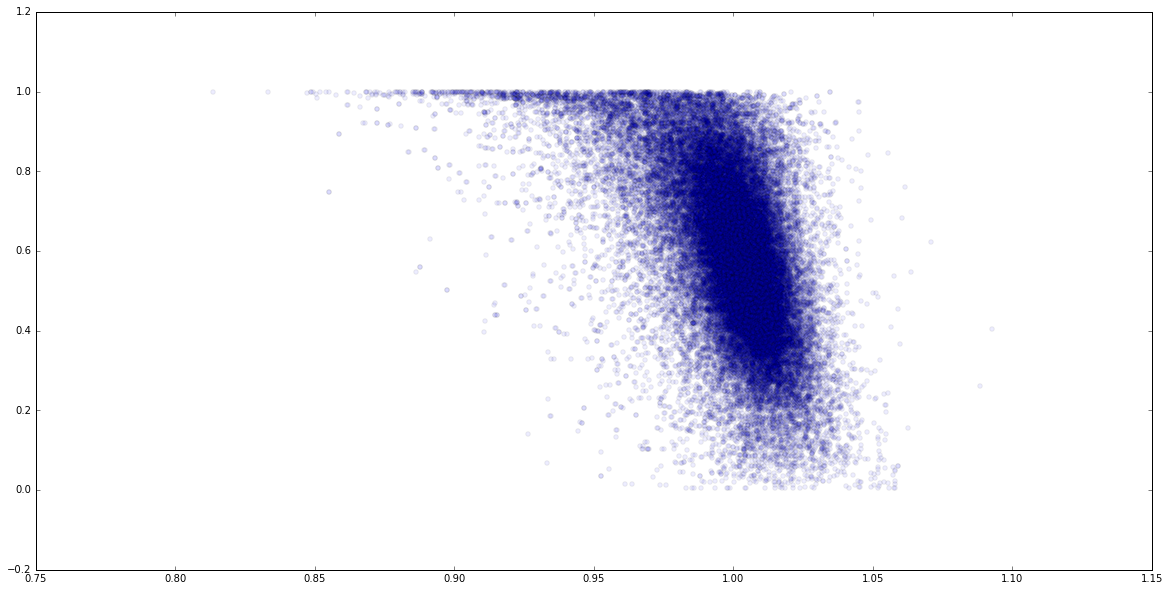

In [177]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df.ranks,df.outcomes,alpha=.07);

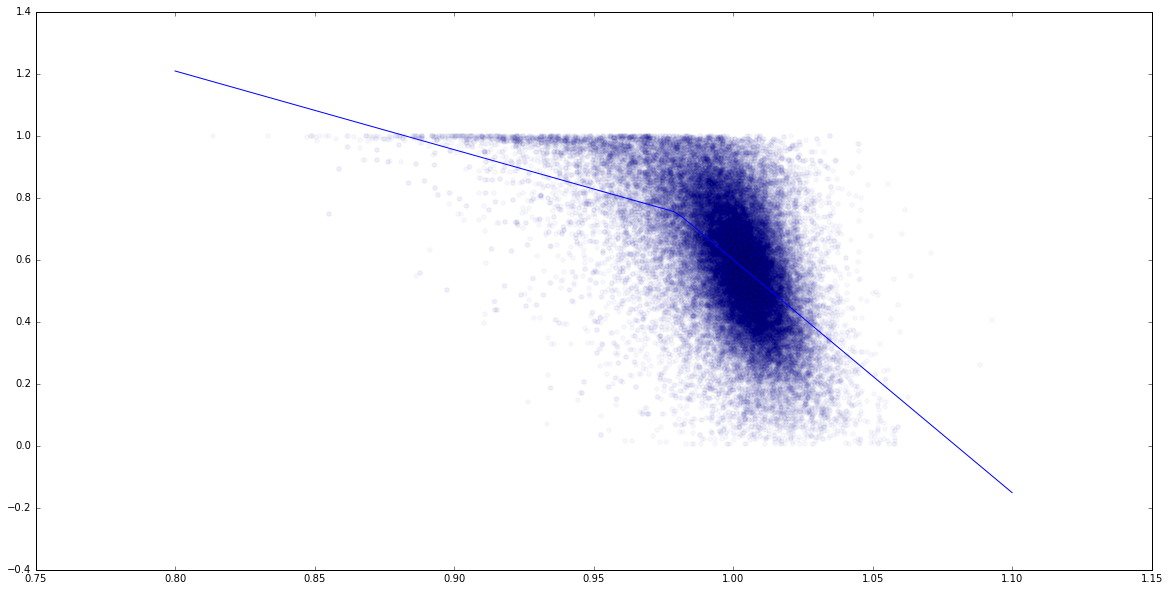

In [188]:
from scipy import optimize


x = df.ranks.values
y = df.outcomes.values

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(.8, 1.10, 100)
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(x, y,alpha=.03)
plt.plot(xd, piecewise_linear(xd, *p));

In [88]:
X,y = df[['ranks','rep_pct']].values,df.outcomes

In [86]:
X = sm.add_constant(X)

In [87]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               outcomes   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     5906.
Date:                Wed, 31 Aug 2016   Prob (F-statistic):               0.00
Time:                        20:37:00   Log-Likelihood:                 6825.1
No. Observations:               41406   AIC:                        -1.364e+04
Df Residuals:                   41403   BIC:                        -1.362e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.2162      0.058    107.409      0.0

In [89]:
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)

In [90]:
cross_val_score(ols,X,y,cv=10).mean()

0.2423266785750664

In [135]:
X.shape

(13645, 3)

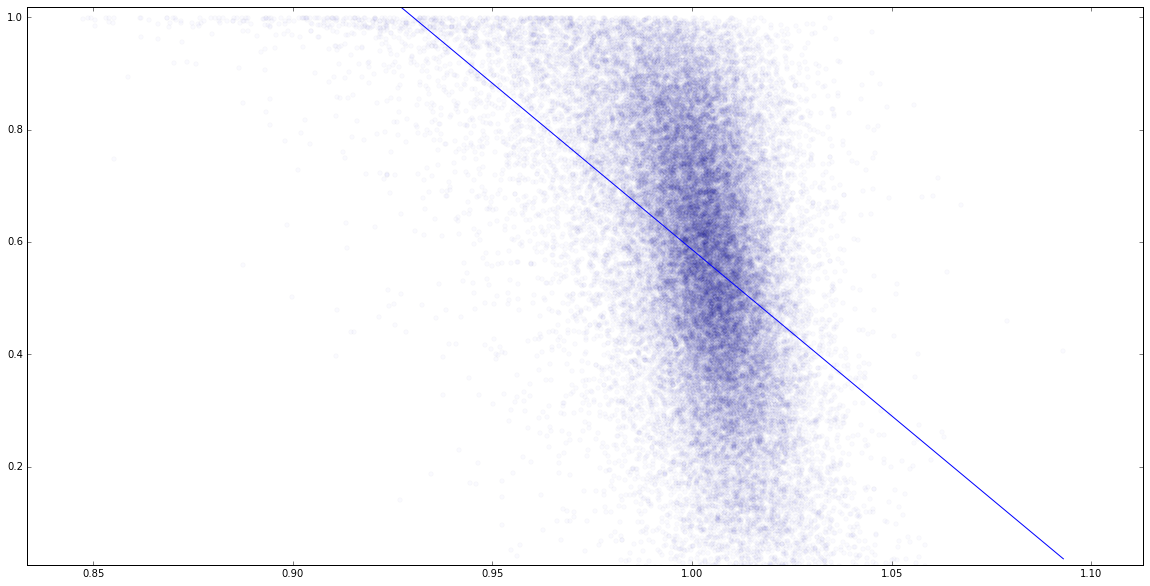

In [34]:
ratings,outcomes = np.array(df.ranks),np.array(df.outcomes)
ols.fit(ratings[:,None],outcomes)
# iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
# predictions_i = iso.predict(np.sort(ratings))
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(ratings,outcomes,alpha=.02)
plt.plot(np.sort(ratings),predictions_o)
# plt.plot(np.sort(ratings),predictions_i)
plt.xlim(df.ranks.min()+.02,df.ranks.max()+.02);
plt.ylim(df.outcomes.min()+.02,df.outcomes.max()+.02);

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


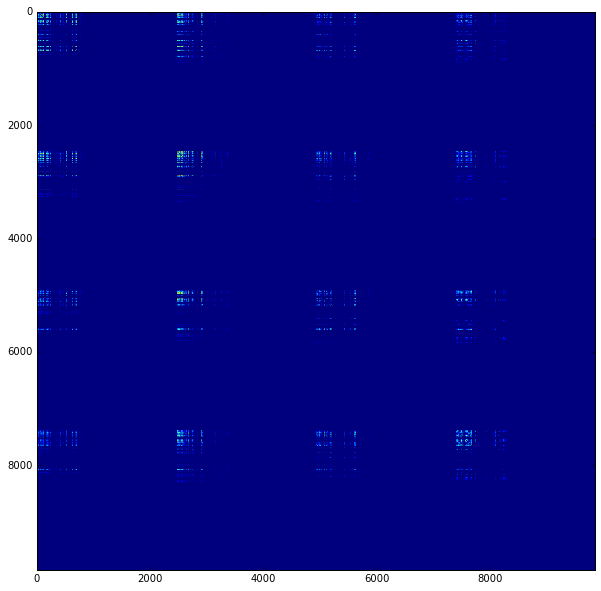

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A[10*n_players:14*n_players,10*n_players:14*n_players].toarray());

In [156]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[0]}).sort_values('rank',ascending=False).dropna()

,player_ind,player_name,rank
13,13,"Singh, Vijay",1.059954
45,45,"Faxon, Brad",1.056565
27,27,"Goosen, Retief",1.048116
180,180,"Weir, Mike",1.045884
162,162,"Mickelson, Phil",1.043698
30,30,"Rollins, John",1.041482
49,49,"Huston, John",1.040823
33,33,"Donald, Luke",1.038114
84,84,"Wilson, Dean",1.037730
82,82,"Lickliter II, Frank",1.037002


In [91]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [185]:
inds_to_plot = [names_to_ind['Johnson, Dustin'],
                names_to_ind['Mickelson, Phil']]

#names_to_ind['Woods, Tiger'],names_to_ind['Day, Jason'],names_to_ind['Donald, Luke']
#names_to_ind['Stricker, Steve'],names_to_ind['Spieth, Jordan'],

In [186]:
from numpy import trapz

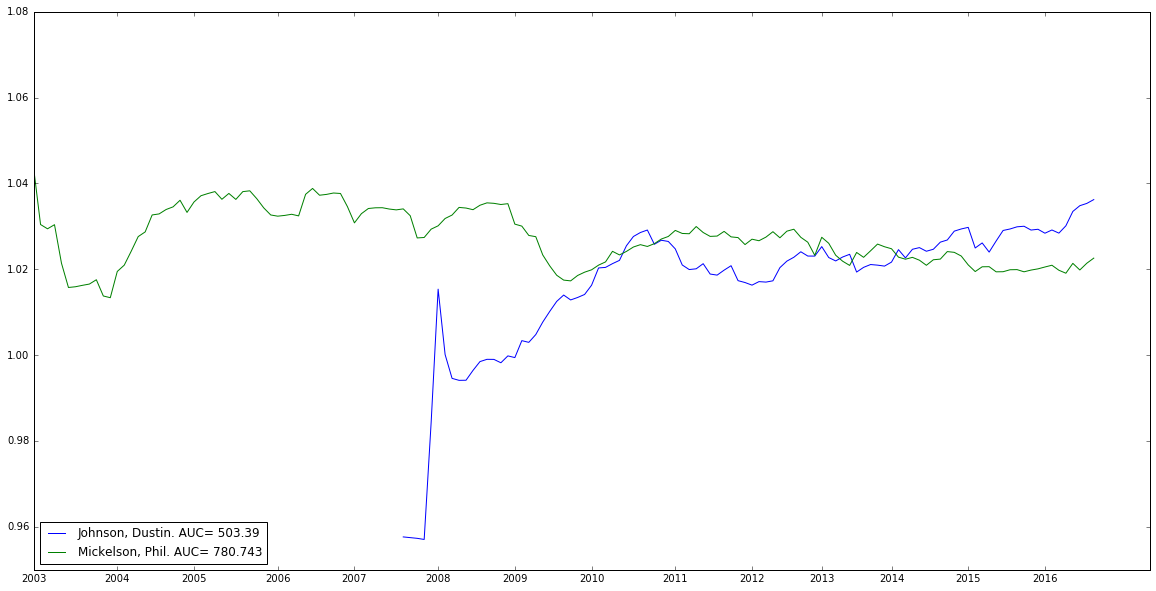

In [187]:
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    y = np.array([ranks[i][j] for i in range(len(ranks))])
    y = y[np.logical_not(np.isnan(y))]
    area = trapz(y, dx=5)
    plt.plot([ranks[i][j] for i in range(len(ranks))],label = inds_to_name[j]+'. AUC= %g' % area);
plt.legend(loc=3);
plt.xticks([i[1] for i in year_inds], [i[0] for i in year_inds]);
plt.ylim(.95,1.08);

In [102]:
year_inds = [max([map(int,[i.split(',')[0] for i in j])]) for j in tournament_groups]

In [103]:
from collections import Counter
year_inds = [Counter(i) for i in year_inds]

In [104]:
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]

In [105]:
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [106]:
year_inds

[(2003, 0),
 (2004, 12),
 (2005, 23),
 (2006, 35),
 (2007, 46),
 (2008, 58),
 (2009, 69),
 (2010, 80),
 (2011, 92),
 (2012, 103),
 (2013, 113),
 (2014, 123),
 (2015, 134),
 (2016, 145)]